In [1]:
%matplotlib inline


Word2Vec Model
==============

Introduces Gensim's Word2Vec model and demonstrates its use on the `Lee Evaluation Corpus
<https://hekyll.services.adelaide.edu.au/dspace/bitstream/2440/28910/1/hdl_28910.pdf>`_.



In [2]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In case you missed the buzz, Word2Vec is a widely used algorithm based on neural
networks, commonly referred to as "deep learning" (though word2vec itself is rather shallow).
Using large amounts of unannotated plain text, word2vec learns relationships
between words automatically. The output are vectors, one vector per word,
with remarkable linear relationships that allow us to do things like:

* vec("king") - vec("man") + vec("woman") =~ vec("queen")
* vec("Montreal Canadiens") – vec("Montreal") + vec("Toronto") =~ vec("Toronto Maple Leafs").

Word2vec is very useful in `automatic text tagging
<https://github.com/RaRe-Technologies/movie-plots-by-genre>`_\ , recommender
systems and machine translation.

This tutorial:

#. Introduces ``Word2Vec`` as an improvement over traditional bag-of-words
#. Shows off a demo of ``Word2Vec`` using a pre-trained model
#. Demonstrates training a new model from your own data
#. Demonstrates loading and saving models
#. Introduces several training parameters and demonstrates their effect
#. Discusses memory requirements
#. Visualizes Word2Vec embeddings by applying dimensionality reduction

Review: Bag-of-words
--------------------

.. Note:: Feel free to skip these review sections if you're already familiar with the models.

You may be familiar with the `bag-of-words model
<https://en.wikipedia.org/wiki/Bag-of-words_model>`_ from the
`core_concepts_vector` section.
This model transforms each document to a fixed-length vector of integers.
For example, given the sentences:

- ``John likes to watch movies. Mary likes movies too.``
- ``John also likes to watch football games. Mary hates football.``

The model outputs the vectors:

- ``[1, 2, 1, 1, 2, 1, 1, 0, 0, 0, 0]``
- ``[1, 1, 1, 1, 0, 1, 0, 1, 2, 1, 1]``

Each vector has 10 elements, where each element counts the number of times a
particular word occurred in the document.
The order of elements is arbitrary.
In the example above, the order of the elements corresponds to the words:
``["John", "likes", "to", "watch", "movies", "Mary", "too", "also", "football", "games", "hates"]``.

Bag-of-words models are surprisingly effective, but have several weaknesses.

First, they lose all information about word order: "John likes Mary" and
"Mary likes John" correspond to identical vectors. There is a solution: bag
of `n-grams <https://en.wikipedia.org/wiki/N-gram>`__
models consider word phrases of length n to represent documents as
fixed-length vectors to capture local word order but suffer from data
sparsity and high dimensionality.

Second, the model does not attempt to learn the meaning of the underlying
words, and as a consequence, the distance between vectors doesn't always
reflect the difference in meaning.  The ``Word2Vec`` model addresses this
second problem.

Introducing: the ``Word2Vec`` Model
-----------------------------------

``Word2Vec`` is a more recent model that embeds words in a lower-dimensional
vector space using a shallow neural network. The result is a set of
word-vectors where vectors close together in vector space have similar
meanings based on context, and word-vectors distant to each other have
differing meanings. For example, ``strong`` and ``powerful`` would be close
together and ``strong`` and ``Paris`` would be relatively far.

The are two versions of this model and :py:class:`~gensim.models.word2vec.Word2Vec`
class implements them both:

1. Skip-grams (SG)
2. Continuous-bag-of-words (CBOW)

.. Important::
  Don't let the implementation details below scare you.
  They're advanced material: if it's too much, then move on to the next section.

The `Word2Vec Skip-gram <http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model>`__
model, for example, takes in pairs (word1, word2) generated by moving a
window across text data, and trains a 1-hidden-layer neural network based on
the synthetic task of given an input word, giving us a predicted probability
distribution of nearby words to the input. A virtual `one-hot
<https://en.wikipedia.org/wiki/One-hot>`__ encoding of words
goes through a 'projection layer' to the hidden layer; these projection
weights are later interpreted as the word embeddings. So if the hidden layer
has 300 neurons, this network will give us 300-dimensional word embeddings.

Continuous-bag-of-words Word2vec is very similar to the skip-gram model. It
is also a 1-hidden-layer neural network. The synthetic training task now uses
the average of multiple input context words, rather than a single word as in
skip-gram, to predict the center word. Again, the projection weights that
turn one-hot words into averageable vectors, of the same width as the hidden
layer, are interpreted as the word embeddings.




Word2Vec Demo
-------------

To see what ``Word2Vec`` can do, let's download a pre-trained model and play
around with it. We will fetch the Word2Vec model trained on part of the
Google News dataset, covering approximately 3 million words and phrases. Such
a model can take hours to train, but since it's already available,
downloading and loading it with Gensim takes minutes.

.. Important::
  The model is approximately 2GB, so you'll need a decent network connection
  to proceed.  Otherwise, skip ahead to the "Training Your Own Model" section
  below.

You may also check out an `online word2vec demo
<http://radimrehurek.com/2014/02/word2vec-tutorial/#app>`_ where you can try
this vector algebra for yourself. That demo runs ``word2vec`` on the
**entire** Google News dataset, of **about 100 billion words**.




In [6]:
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')

2025-03-27 14:15:23,239 : INFO : loading projection weights from /Users/vip/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz
2025-03-27 14:15:43,108 : INFO : KeyedVectors lifecycle event {'msg': 'loaded (3000000, 300) matrix of type float32 from /Users/vip/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz', 'binary': True, 'encoding': 'utf8', 'datetime': '2025-03-27T14:15:43.108564', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-14.7.4-arm64-arm-64bit', 'event': 'load_word2vec_format'}


A common operation is to retrieve the vocabulary of a model. That is trivial:



In [7]:
for index, word in enumerate(wv.index_to_key):
    if index == 10:
        break
    print(f"word #{index}/{len(wv.index_to_key)} is {word}")

word #0/3000000 is </s>
word #1/3000000 is in
word #2/3000000 is for
word #3/3000000 is that
word #4/3000000 is is
word #5/3000000 is on
word #6/3000000 is ##
word #7/3000000 is The
word #8/3000000 is with
word #9/3000000 is said


We can easily obtain vectors for terms the model is familiar with:




In [8]:
vec_king = wv['king']

Unfortunately, the model is unable to infer vectors for unfamiliar words.
This is one limitation of Word2Vec: if this limitation matters to you, check
out the FastText model.




In [9]:
try:
    vec_cameroon = wv['cameroon']
except KeyError:
    print("The word 'cameroon' does not appear in this model")

The word 'cameroon' does not appear in this model


Moving on, ``Word2Vec`` supports several word similarity tasks out of the
box.  You can see how the similarity intuitively decreases as the words get
less and less similar.




In [10]:
pairs = [
    ('car', 'minivan'),   # a minivan is a kind of car
    ('car', 'bicycle'),   # still a wheeled vehicle
    ('car', 'airplane'),  # ok, no wheels, but still a vehicle
    ('car', 'cereal'),    # ... and so on
    ('car', 'communism'),
]
for w1, w2 in pairs:
    print('%r\t%r\t%.2f' % (w1, w2, wv.similarity(w1, w2)))

'car'	'minivan'	0.69
'car'	'bicycle'	0.54
'car'	'airplane'	0.42
'car'	'cereal'	0.14
'car'	'communism'	0.06


Print the 5 most similar words to "car" or "minivan"



In [11]:
print(wv.most_similar(positive=['car', 'minivan'], topn=5))

[('SUV', 0.8532192707061768), ('vehicle', 0.8175783753395081), ('pickup_truck', 0.7763689756393433), ('Jeep', 0.7567334175109863), ('Ford_Explorer', 0.7565719485282898)]


Which of the below does not belong in the sequence?



In [12]:
print(wv.doesnt_match(['fire', 'water', 'land', 'sea', 'air', 'car']))

car


Training Your Own Model
-----------------------

To start, you'll need some data for training the model. For the following
examples, we'll use the `Lee Evaluation Corpus
<https://hekyll.services.adelaide.edu.au/dspace/bitstream/2440/28910/1/hdl_28910.pdf>`_
(which you `already have
<https://github.com/RaRe-Technologies/gensim/blob/develop/gensim/test/test_data/lee_background.cor>`_
if you've installed Gensim).

This corpus is small enough to fit entirely in memory, but we'll implement a
memory-friendly iterator that reads it line-by-line to demonstrate how you
would handle a larger corpus.




In [13]:
from gensim.test.utils import datapath
from gensim import utils

class MyCorpus:
    """An iterator that yields sentences (lists of str)."""

    def __iter__(self):
        corpus_path = datapath('lee_background.cor')
        for line in open(corpus_path):
            # assume there's one document per line, tokens separated by whitespace
            yield utils.simple_preprocess(line)

2025-03-27 14:16:43,057 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2025-03-27 14:16:43,058 : INFO : built Dictionary<12 unique tokens: ['computer', 'human', 'interface', 'response', 'survey']...> from 9 documents (total 29 corpus positions)
2025-03-27 14:16:43,058 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<12 unique tokens: ['computer', 'human', 'interface', 'response', 'survey']...> from 9 documents (total 29 corpus positions)", 'datetime': '2025-03-27T14:16:43.058804', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-14.7.4-arm64-arm-64bit', 'event': 'created'}


If we wanted to do any custom preprocessing, e.g. decode a non-standard
encoding, lowercase, remove numbers, extract named entities... All of this can
be done inside the ``MyCorpus`` iterator and ``word2vec`` doesn’t need to
know. All that is required is that the input yields one sentence (list of
utf8 words) after another.

Let's go ahead and train a model on our corpus.  Don't worry about the
training parameters much for now, we'll revisit them later.




In [14]:
import gensim.models

sentences = MyCorpus()
model = gensim.models.Word2Vec(sentences=sentences)

2025-03-27 14:17:00,060 : INFO : collecting all words and their counts
2025-03-27 14:17:00,063 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2025-03-27 14:17:00,127 : INFO : collected 6981 word types from a corpus of 58152 raw words and 300 sentences
2025-03-27 14:17:00,127 : INFO : Creating a fresh vocabulary
2025-03-27 14:17:00,131 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 1750 unique words (25.07% of original 6981, drops 5231)', 'datetime': '2025-03-27T14:17:00.131400', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-14.7.4-arm64-arm-64bit', 'event': 'prepare_vocab'}
2025-03-27 14:17:00,131 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 leaves 49335 word corpus (84.84% of original 58152, drops 8817)', 'datetime': '2025-03-27T14:17:00.131712', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (c

Once we have our model, we can use it in the same way as in the demo above.

The main part of the model is ``model.wv``\ , where "wv" stands for "word vectors".




In [15]:
vec_king = model.wv['king']

Retrieving the vocabulary works the same way:



In [16]:
for index, word in enumerate(wv.index_to_key):
    if index == 10:
        break
    print(f"word #{index}/{len(wv.index_to_key)} is {word}")

word #0/3000000 is </s>
word #1/3000000 is in
word #2/3000000 is for
word #3/3000000 is that
word #4/3000000 is is
word #5/3000000 is on
word #6/3000000 is ##
word #7/3000000 is The
word #8/3000000 is with
word #9/3000000 is said


Storing and loading models
--------------------------

You'll notice that training non-trivial models can take time.  Once you've
trained your model and it works as expected, you can save it to disk.  That
way, you don't have to spend time training it all over again later.

You can store/load models using the standard gensim methods:




In [17]:
import tempfile

with tempfile.NamedTemporaryFile(prefix='gensim-model-', delete=False) as tmp:
    temporary_filepath = tmp.name
    model.save(temporary_filepath)
    #
    # The model is now safely stored in the filepath.
    # You can copy it to other machines, share it with others, etc.
    #
    # To load a saved model:
    #
    new_model = gensim.models.Word2Vec.load(temporary_filepath)

2025-03-27 14:17:15,337 : INFO : Word2Vec lifecycle event {'fname_or_handle': '/var/folders/w_/5zj48w1d0xb7ycgdm6pk40v00000gn/T/gensim-model-k8l_1pq4', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2025-03-27T14:17:15.337430', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-14.7.4-arm64-arm-64bit', 'event': 'saving'}
2025-03-27 14:17:15,339 : INFO : not storing attribute cum_table
2025-03-27 14:17:15,345 : INFO : saved /var/folders/w_/5zj48w1d0xb7ycgdm6pk40v00000gn/T/gensim-model-k8l_1pq4
2025-03-27 14:17:15,346 : INFO : loading Word2Vec object from /var/folders/w_/5zj48w1d0xb7ycgdm6pk40v00000gn/T/gensim-model-k8l_1pq4
2025-03-27 14:17:15,347 : INFO : loading wv recursively from /var/folders/w_/5zj48w1d0xb7ycgdm6pk40v00000gn/T/gensim-model-k8l_1pq4.wv.* with mmap=None
2025-03-27 14:17:15,348 : INFO : setting ignored attribute cum_table to None
2025-03-27 14:17:15,356 : INFO

which uses pickle internally, optionally ``mmap``\ ‘ing the model’s internal
large NumPy matrices into virtual memory directly from disk files, for
inter-process memory sharing.

In addition, you can load models created by the original C tool, both using
its text and binary formats::

  model = gensim.models.KeyedVectors.load_word2vec_format('/tmp/vectors.txt', binary=False)
  # using gzipped/bz2 input works too, no need to unzip
  model = gensim.models.KeyedVectors.load_word2vec_format('/tmp/vectors.bin.gz', binary=True)




Training Parameters
-------------------

``Word2Vec`` accepts several parameters that affect both training speed and quality.

min_count
---------

``min_count`` is for pruning the internal dictionary. Words that appear only
once or twice in a billion-word corpus are probably uninteresting typos and
garbage. In addition, there’s not enough data to make any meaningful training
on those words, so it’s best to ignore them:

default value of min_count=5



In [18]:
model = gensim.models.Word2Vec(sentences, min_count=10)

2025-03-27 14:17:26,709 : INFO : collecting all words and their counts
2025-03-27 14:17:26,711 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2025-03-27 14:17:26,773 : INFO : collected 6981 word types from a corpus of 58152 raw words and 300 sentences
2025-03-27 14:17:26,774 : INFO : Creating a fresh vocabulary
2025-03-27 14:17:26,776 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=10 retains 889 unique words (12.73% of original 6981, drops 6092)', 'datetime': '2025-03-27T14:17:26.776847', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-14.7.4-arm64-arm-64bit', 'event': 'prepare_vocab'}
2025-03-27 14:17:26,777 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=10 leaves 43776 word corpus (75.28% of original 58152, drops 14376)', 'datetime': '2025-03-27T14:17:26.777106', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 

vector_size
-----------

``vector_size`` is the number of dimensions (N) of the N-dimensional space that
gensim Word2Vec maps the words onto.

Bigger size values require more training data, but can lead to better (more
accurate) models. Reasonable values are in the tens to hundreds.




In [19]:
# The default value of vector_size is 100.
model = gensim.models.Word2Vec(sentences, vector_size=200)

2025-03-27 14:17:38,448 : INFO : collecting all words and their counts
2025-03-27 14:17:38,452 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2025-03-27 14:17:38,515 : INFO : collected 6981 word types from a corpus of 58152 raw words and 300 sentences
2025-03-27 14:17:38,516 : INFO : Creating a fresh vocabulary
2025-03-27 14:17:38,519 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 1750 unique words (25.07% of original 6981, drops 5231)', 'datetime': '2025-03-27T14:17:38.519961', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-14.7.4-arm64-arm-64bit', 'event': 'prepare_vocab'}
2025-03-27 14:17:38,520 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 leaves 49335 word corpus (84.84% of original 58152, drops 8817)', 'datetime': '2025-03-27T14:17:38.520639', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (c

workers
-------

``workers`` , the last of the major parameters (full list `here
<http://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec>`_)
is for training parallelization, to speed up training:




In [20]:
# default value of workers=3 (tutorial says 1...)
model = gensim.models.Word2Vec(sentences, workers=4)

2025-03-27 14:17:43,033 : INFO : collecting all words and their counts
2025-03-27 14:17:43,040 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2025-03-27 14:17:43,094 : INFO : collected 6981 word types from a corpus of 58152 raw words and 300 sentences
2025-03-27 14:17:43,094 : INFO : Creating a fresh vocabulary
2025-03-27 14:17:43,099 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 1750 unique words (25.07% of original 6981, drops 5231)', 'datetime': '2025-03-27T14:17:43.099101', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-14.7.4-arm64-arm-64bit', 'event': 'prepare_vocab'}
2025-03-27 14:17:43,099 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 leaves 49335 word corpus (84.84% of original 58152, drops 8817)', 'datetime': '2025-03-27T14:17:43.099482', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (c

The ``workers`` parameter only has an effect if you have `Cython
<http://cython.org/>`_ installed. Without Cython, you’ll only be able to use
one core because of the `GIL
<https://wiki.python.org/moin/GlobalInterpreterLock>`_ (and ``word2vec``
training will be `miserably slow
<http://rare-technologies.com/word2vec-in-python-part-two-optimizing/>`_\ ).




Memory
------

At its core, ``word2vec`` model parameters are stored as matrices (NumPy
arrays). Each array is **#vocabulary** (controlled by the ``min_count`` parameter)
times **vector size** (the ``vector_size`` parameter) of floats (single precision aka 4 bytes).

Three such matrices are held in RAM (work is underway to reduce that number
to two, or even one). So if your input contains 100,000 unique words, and you
asked for layer ``vector_size=200``\ , the model will require approx.
``100,000*200*4*3 bytes = ~229MB``.

There’s a little extra memory needed for storing the vocabulary tree (100,000 words would
take a few megabytes), but unless your words are extremely loooong strings, memory
footprint will be dominated by the three matrices above.




Evaluating
----------

``Word2Vec`` training is an unsupervised task, there’s no good way to
objectively evaluate the result. Evaluation depends on your end application.

Google has released their testing set of about 20,000 syntactic and semantic
test examples, following the “A is to B as C is to D” task. It is provided in
the 'datasets' folder.

For example a syntactic analogy of comparative type is ``bad:worse;good:?``.
There are total of 9 types of syntactic comparisons in the dataset like
plural nouns and nouns of opposite meaning.

The semantic questions contain five types of semantic analogies, such as
capital cities (``Paris:France;Tokyo:?``) or family members
(``brother:sister;dad:?``).




Gensim supports the same evaluation set, in exactly the same format:




In [21]:
model.wv.evaluate_word_analogies(datapath('questions-words.txt'))

2025-03-27 14:17:57,250 : INFO : Evaluating word analogies for top 300000 words in the model on /Users/vip/Library/Python/3.9/lib/python/site-packages/gensim/test/test_data/questions-words.txt
2025-03-27 14:17:57,305 : INFO : capital-common-countries: 0.0% (0/6)
2025-03-27 14:17:57,329 : INFO : capital-world: 0.0% (0/2)
2025-03-27 14:17:57,373 : INFO : family: 0.0% (0/6)
2025-03-27 14:17:57,407 : INFO : gram3-comparative: 0.0% (0/20)
2025-03-27 14:17:57,431 : INFO : gram4-superlative: 0.0% (0/12)
2025-03-27 14:17:57,457 : INFO : gram5-present-participle: 0.0% (0/20)
2025-03-27 14:17:57,504 : INFO : gram6-nationality-adjective: 0.0% (0/30)
2025-03-27 14:17:57,536 : INFO : gram7-past-tense: 0.0% (0/20)
2025-03-27 14:17:57,581 : INFO : gram8-plural: 0.0% (0/30)
2025-03-27 14:17:57,585 : INFO : Quadruplets with out-of-vocabulary words: 99.3%
2025-03-27 14:17:57,586 : INFO : NB: analogies containing OOV words were skipped from evaluation! To change this behavior, use "dummy4unknown=True"
20

(0.0,
 [{'section': 'capital-common-countries',
   'correct': [],
   'incorrect': [('CANBERRA', 'AUSTRALIA', 'KABUL', 'AFGHANISTAN'),
    ('CANBERRA', 'AUSTRALIA', 'PARIS', 'FRANCE'),
    ('KABUL', 'AFGHANISTAN', 'PARIS', 'FRANCE'),
    ('KABUL', 'AFGHANISTAN', 'CANBERRA', 'AUSTRALIA'),
    ('PARIS', 'FRANCE', 'CANBERRA', 'AUSTRALIA'),
    ('PARIS', 'FRANCE', 'KABUL', 'AFGHANISTAN')]},
  {'section': 'capital-world',
   'correct': [],
   'incorrect': [('CANBERRA', 'AUSTRALIA', 'KABUL', 'AFGHANISTAN'),
    ('KABUL', 'AFGHANISTAN', 'PARIS', 'FRANCE')]},
  {'section': 'currency', 'correct': [], 'incorrect': []},
  {'section': 'city-in-state', 'correct': [], 'incorrect': []},
  {'section': 'family',
   'correct': [],
   'incorrect': [('HE', 'SHE', 'HIS', 'HER'),
    ('HE', 'SHE', 'MAN', 'WOMAN'),
    ('HIS', 'HER', 'MAN', 'WOMAN'),
    ('HIS', 'HER', 'HE', 'SHE'),
    ('MAN', 'WOMAN', 'HE', 'SHE'),
    ('MAN', 'WOMAN', 'HIS', 'HER')]},
  {'section': 'gram1-adjective-to-adverb', 'correct': [

This ``evaluate_word_analogies`` method takes an `optional parameter
<http://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.KeyedVectors.evaluate_word_analogies>`_
``restrict_vocab`` which limits which test examples are to be considered.




In the December 2016 release of Gensim we added a better way to evaluate semantic similarity.

By default it uses an academic dataset WS-353 but one can create a dataset
specific to your business based on it. It contains word pairs together with
human-assigned similarity judgments. It measures the relatedness or
co-occurrence of two words. For example, 'coast' and 'shore' are very similar
as they appear in the same context. At the same time 'clothes' and 'closet'
are less similar because they are related but not interchangeable.




In [22]:
model.wv.evaluate_word_pairs(datapath('wordsim353.tsv'))

2025-03-27 14:18:01,673 : INFO : Skipping line #2 with OOV words: love	sex	6.77
2025-03-27 14:18:01,675 : INFO : Skipping line #3 with OOV words: tiger	cat	7.35
2025-03-27 14:18:01,675 : INFO : Skipping line #4 with OOV words: tiger	tiger	10.00
2025-03-27 14:18:01,676 : INFO : Skipping line #5 with OOV words: book	paper	7.46
2025-03-27 14:18:01,676 : INFO : Skipping line #6 with OOV words: computer	keyboard	7.62
2025-03-27 14:18:01,677 : INFO : Skipping line #7 with OOV words: computer	internet	7.58
2025-03-27 14:18:01,679 : INFO : Skipping line #9 with OOV words: train	car	6.31
2025-03-27 14:18:01,680 : INFO : Skipping line #10 with OOV words: telephone	communication	7.50
2025-03-27 14:18:01,681 : INFO : Skipping line #14 with OOV words: bread	butter	6.19
2025-03-27 14:18:01,681 : INFO : Skipping line #15 with OOV words: cucumber	potato	5.92
2025-03-27 14:18:01,682 : INFO : Skipping line #16 with OOV words: doctor	nurse	7.00
2025-03-27 14:18:01,682 : INFO : Skipping line #18 with OOV 

2025-03-27 14:18:01,709 : INFO : Skipping line #112 with OOV words: tiger	mammal	6.85
2025-03-27 14:18:01,709 : INFO : Skipping line #113 with OOV words: tiger	animal	7.00
2025-03-27 14:18:01,709 : INFO : Skipping line #114 with OOV words: tiger	organism	4.77
2025-03-27 14:18:01,709 : INFO : Skipping line #115 with OOV words: tiger	fauna	5.62
2025-03-27 14:18:01,709 : INFO : Skipping line #116 with OOV words: tiger	zoo	5.87
2025-03-27 14:18:01,710 : INFO : Skipping line #117 with OOV words: psychology	psychiatry	8.08
2025-03-27 14:18:01,710 : INFO : Skipping line #118 with OOV words: psychology	anxiety	7.00
2025-03-27 14:18:01,710 : INFO : Skipping line #119 with OOV words: psychology	fear	6.85
2025-03-27 14:18:01,710 : INFO : Skipping line #120 with OOV words: psychology	depression	7.42
2025-03-27 14:18:01,710 : INFO : Skipping line #121 with OOV words: psychology	clinic	6.58
2025-03-27 14:18:01,711 : INFO : Skipping line #122 with OOV words: psychology	doctor	6.42
2025-03-27 14:18:01

2025-03-27 14:18:01,730 : INFO : Skipping line #227 with OOV words: consumer	confidence	4.13
2025-03-27 14:18:01,730 : INFO : Skipping line #228 with OOV words: consumer	energy	4.75
2025-03-27 14:18:01,731 : INFO : Skipping line #231 with OOV words: credit	card	8.06
2025-03-27 14:18:01,731 : INFO : Skipping line #233 with OOV words: hotel	reservation	8.03
2025-03-27 14:18:01,731 : INFO : Skipping line #234 with OOV words: grocery	money	5.94
2025-03-27 14:18:01,731 : INFO : Skipping line #235 with OOV words: registration	arrangement	6.00
2025-03-27 14:18:01,731 : INFO : Skipping line #236 with OOV words: arrangement	accommodation	5.41
2025-03-27 14:18:01,732 : INFO : Skipping line #238 with OOV words: type	kind	8.97
2025-03-27 14:18:01,732 : INFO : Skipping line #239 with OOV words: arrival	hotel	6.00
2025-03-27 14:18:01,732 : INFO : Skipping line #240 with OOV words: bed	closet	6.72
2025-03-27 14:18:01,732 : INFO : Skipping line #241 with OOV words: closet	clothes	8.00
2025-03-27 14:18

2025-03-27 14:18:01,750 : INFO : Skipping line #340 with OOV words: chance	credibility	3.88
2025-03-27 14:18:01,750 : INFO : Skipping line #341 with OOV words: exhibit	memorabilia	5.31
2025-03-27 14:18:01,750 : INFO : Skipping line #342 with OOV words: concert	virtuoso	6.81
2025-03-27 14:18:01,751 : INFO : Skipping line #343 with OOV words: rock	jazz	7.59
2025-03-27 14:18:01,751 : INFO : Skipping line #344 with OOV words: museum	theater	7.19
2025-03-27 14:18:01,751 : INFO : Skipping line #345 with OOV words: observation	architecture	4.38
2025-03-27 14:18:01,751 : INFO : Skipping line #347 with OOV words: preservation	world	6.19
2025-03-27 14:18:01,752 : INFO : Skipping line #348 with OOV words: admission	ticket	7.69
2025-03-27 14:18:01,752 : INFO : Skipping line #349 with OOV words: shower	thunderstorm	6.31
2025-03-27 14:18:01,752 : INFO : Skipping line #350 with OOV words: shower	flood	6.03
2025-03-27 14:18:01,752 : INFO : Skipping line #354 with OOV words: architecture	century	3.78
2

(PearsonRResult(statistic=0.17147094626235634, pvalue=0.19019767223751688),
 SignificanceResult(statistic=0.14264276870117013, pvalue=0.276933183632982),
 83.0028328611898)

.. Important::
  Good performance on Google's or WS-353 test set doesn’t mean word2vec will
  work well in your application, or vice versa. It’s always best to evaluate
  directly on your intended task. For an example of how to use word2vec in a
  classifier pipeline, see this `tutorial
  <https://github.com/RaRe-Technologies/movie-plots-by-genre>`_.




Online training / Resuming training
-----------------------------------

Advanced users can load a model and continue training it with more sentences
and `new vocabulary words <online_w2v_tutorial.ipynb>`_:




In [23]:
model = gensim.models.Word2Vec.load(temporary_filepath)
more_sentences = [
    ['Advanced', 'users', 'can', 'load', 'a', 'model',
     'and', 'continue', 'training', 'it', 'with', 'more', 'sentences'],
]
model.build_vocab(more_sentences, update=True)
model.train(more_sentences, total_examples=model.corpus_count, epochs=model.epochs)

# cleaning up temporary file
import os
os.remove(temporary_filepath)

2025-03-27 14:18:17,184 : INFO : loading Word2Vec object from /var/folders/w_/5zj48w1d0xb7ycgdm6pk40v00000gn/T/gensim-model-k8l_1pq4
2025-03-27 14:18:17,191 : INFO : loading wv recursively from /var/folders/w_/5zj48w1d0xb7ycgdm6pk40v00000gn/T/gensim-model-k8l_1pq4.wv.* with mmap=None
2025-03-27 14:18:17,192 : INFO : setting ignored attribute cum_table to None
2025-03-27 14:18:17,201 : INFO : Word2Vec lifecycle event {'fname': '/var/folders/w_/5zj48w1d0xb7ycgdm6pk40v00000gn/T/gensim-model-k8l_1pq4', 'datetime': '2025-03-27T14:18:17.201501', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-14.7.4-arm64-arm-64bit', 'event': 'loaded'}
2025-03-27 14:18:17,202 : INFO : collecting all words and their counts
2025-03-27 14:18:17,202 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2025-03-27 14:18:17,203 : INFO : collected 13 word types from a corpus of 13 raw words and 1 sentences
2025-03-27

You may need to tweak the ``total_words`` parameter to ``train()``,
depending on what learning rate decay you want to simulate.

Note that it’s not possible to resume training with models generated by the C
tool, ``KeyedVectors.load_word2vec_format()``. You can still use them for
querying/similarity, but information vital for training (the vocab tree) is
missing there.




Training Loss Computation
-------------------------

The parameter ``compute_loss`` can be used to toggle computation of loss
while training the Word2Vec model. The computed loss is stored in the model
attribute ``running_training_loss`` and can be retrieved using the function
``get_latest_training_loss`` as follows :




In [24]:
# instantiating and training the Word2Vec model
model_with_loss = gensim.models.Word2Vec(
    sentences,
    min_count=1,
    compute_loss=True,
    hs=0,
    sg=1,
    seed=42,
)

# getting the training loss value
training_loss = model_with_loss.get_latest_training_loss()
print(training_loss)

2025-03-27 14:18:27,135 : INFO : collecting all words and their counts
2025-03-27 14:18:27,141 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2025-03-27 14:18:27,196 : INFO : collected 6981 word types from a corpus of 58152 raw words and 300 sentences
2025-03-27 14:18:27,197 : INFO : Creating a fresh vocabulary
2025-03-27 14:18:27,209 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 6981 unique words (100.00% of original 6981, drops 0)', 'datetime': '2025-03-27T14:18:27.209211', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-14.7.4-arm64-arm-64bit', 'event': 'prepare_vocab'}
2025-03-27 14:18:27,209 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 58152 word corpus (100.00% of original 58152, drops 0)', 'datetime': '2025-03-27T14:18:27.209743', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang

1374090.375


Benchmarks
----------

Let's run some benchmarks to see effect of the training loss computation code
on training time.

We'll use the following data for the benchmarks:

#. Lee Background corpus: included in gensim's test data
#. Text8 corpus.  To demonstrate the effect of corpus size, we'll look at the
   first 1MB, 10MB, 50MB of the corpus, as well as the entire thing.




In [25]:
import io
import os

import gensim.models.word2vec
import gensim.downloader as api
import smart_open


def head(path, size):
    with smart_open.open(path) as fin:
        return io.StringIO(fin.read(size))


def generate_input_data():
    lee_path = datapath('lee_background.cor')
    ls = gensim.models.word2vec.LineSentence(lee_path)
    ls.name = '25kB'
    yield ls

    text8_path = api.load('text8').fn
    labels = ('1MB', '10MB', '50MB', '100MB')
    sizes = (1024 ** 2, 10 * 1024 ** 2, 50 * 1024 ** 2, 100 * 1024 ** 2)
    for l, s in zip(labels, sizes):
        ls = gensim.models.word2vec.LineSentence(head(text8_path, s))
        ls.name = l
        yield ls


input_data = list(generate_input_data())

We now compare the training time taken for different combinations of input
data and model training parameters like ``hs`` and ``sg``.

For each combination, we repeat the test several times to obtain the mean and
standard deviation of the test duration.




In [26]:
# Temporarily reduce logging verbosity
logging.root.level = logging.ERROR

import time
import numpy as np
import pandas as pd

train_time_values = []
seed_val = 42
sg_values = [0, 1]
hs_values = [0, 1]

fast = True
if fast:
    input_data_subset = input_data[:3]
else:
    input_data_subset = input_data


for data in input_data_subset:
    for sg_val in sg_values:
        for hs_val in hs_values:
            for loss_flag in [True, False]:
                time_taken_list = []
                for i in range(3):
                    start_time = time.time()
                    w2v_model = gensim.models.Word2Vec(
                        data,
                        compute_loss=loss_flag,
                        sg=sg_val,
                        hs=hs_val,
                        seed=seed_val,
                    )
                    time_taken_list.append(time.time() - start_time)

                time_taken_list = np.array(time_taken_list)
                time_mean = np.mean(time_taken_list)
                time_std = np.std(time_taken_list)

                model_result = {
                    'train_data': data.name,
                    'compute_loss': loss_flag,
                    'sg': sg_val,
                    'hs': hs_val,
                    'train_time_mean': time_mean,
                    'train_time_std': time_std,
                }
                print("Word2vec model #%i: %s" % (len(train_time_values), model_result))
                train_time_values.append(model_result)

train_times_table = pd.DataFrame(train_time_values)
train_times_table = train_times_table.sort_values(
    by=['train_data', 'sg', 'hs', 'compute_loss'],
    ascending=[False, False, True, False],
)
print(train_times_table)

2025-03-27 14:18:51,580 : INFO : collecting all words and their counts
2025-03-27 14:18:51,581 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2025-03-27 14:18:51,591 : INFO : collected 10781 word types from a corpus of 59890 raw words and 300 sentences
2025-03-27 14:18:51,591 : INFO : Creating a fresh vocabulary
2025-03-27 14:18:51,598 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 1762 unique words (16.34% of original 10781, drops 9019)', 'datetime': '2025-03-27T14:18:51.598350', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-14.7.4-arm64-arm-64bit', 'event': 'prepare_vocab'}
2025-03-27 14:18:51,599 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 leaves 46084 word corpus (76.95% of original 59890, drops 13806)', 'datetime': '2025-03-27T14:18:51.598999', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0

2025-03-27 14:18:51,890 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 leaves 46084 word corpus (76.95% of original 59890, drops 13806)', 'datetime': '2025-03-27T14:18:51.890416', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-14.7.4-arm64-arm-64bit', 'event': 'prepare_vocab'}
2025-03-27 14:18:51,894 : INFO : deleting the raw counts dictionary of 10781 items
2025-03-27 14:18:51,894 : INFO : sample=0.001 downsamples 45 most-common words
2025-03-27 14:18:51,895 : INFO : Word2Vec lifecycle event {'msg': 'downsampling leaves estimated 32610.61883565215 word corpus (70.8%% of prior 46084)', 'datetime': '2025-03-27T14:18:51.895118', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-14.7.4-arm64-arm-64bit', 'event': 'prepare_vocab'}
2025-03-27 14:18:51,901 : INFO : estimated required memory for 1762 words and 100 dimensi

2025-03-27 14:18:52,167 : INFO : sample=0.001 downsamples 45 most-common words
2025-03-27 14:18:52,168 : INFO : Word2Vec lifecycle event {'msg': 'downsampling leaves estimated 32610.61883565215 word corpus (70.8%% of prior 46084)', 'datetime': '2025-03-27T14:18:52.168036', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-14.7.4-arm64-arm-64bit', 'event': 'prepare_vocab'}
2025-03-27 14:18:52,173 : INFO : estimated required memory for 1762 words and 100 dimensions: 2290600 bytes
2025-03-27 14:18:52,174 : INFO : resetting layer weights
2025-03-27 14:18:52,175 : INFO : Word2Vec lifecycle event {'update': False, 'trim_rule': 'None', 'datetime': '2025-03-27T14:18:52.175021', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-14.7.4-arm64-arm-64bit', 'event': 'build_vocab'}
2025-03-27 14:18:52,175 : INFO : Word2Vec lifecycle event {'msg': 't

Word2vec model #0: {'train_data': '25kB', 'compute_loss': True, 'sg': 0, 'hs': 0, 'train_time_mean': 0.14458235104878744, 'train_time_std': 0.004779222957497731}


2025-03-27 14:18:52,216 : INFO : EPOCH 1: training on 59890 raw words (32692 effective words) took 0.0s, 1654171 effective words/s
2025-03-27 14:18:52,236 : INFO : EPOCH 2: training on 59890 raw words (32568 effective words) took 0.0s, 1656253 effective words/s
2025-03-27 14:18:52,257 : INFO : EPOCH 3: training on 59890 raw words (32601 effective words) took 0.0s, 1662924 effective words/s
2025-03-27 14:18:52,278 : INFO : EPOCH 4: training on 59890 raw words (32650 effective words) took 0.0s, 1573516 effective words/s
2025-03-27 14:18:52,278 : INFO : Word2Vec lifecycle event {'msg': 'training on 299450 raw words (163054 effective words) took 0.1s, 1575040 effective words/s', 'datetime': '2025-03-27T14:18:52.278919', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-14.7.4-arm64-arm-64bit', 'event': 'train'}
2025-03-27 14:18:52,279 : INFO : Word2Vec lifecycle event {'params': 'Word2Vec<vocab=1762, vector_size=1

2025-03-27 14:18:52,569 : INFO : EPOCH 2: training on 59890 raw words (32630 effective words) took 0.0s, 870937 effective words/s
2025-03-27 14:18:52,603 : INFO : EPOCH 3: training on 59890 raw words (32560 effective words) took 0.0s, 971933 effective words/s


Word2vec model #1: {'train_data': '25kB', 'compute_loss': False, 'sg': 0, 'hs': 0, 'train_time_mean': 0.131805419921875, 'train_time_std': 0.002030210634488772}


2025-03-27 14:18:52,640 : INFO : EPOCH 4: training on 59890 raw words (32594 effective words) took 0.0s, 913596 effective words/s
2025-03-27 14:18:52,640 : INFO : Word2Vec lifecycle event {'msg': 'training on 299450 raw words (162879 effective words) took 0.2s, 891681 effective words/s', 'datetime': '2025-03-27T14:18:52.640669', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-14.7.4-arm64-arm-64bit', 'event': 'train'}
2025-03-27 14:18:52,640 : INFO : Word2Vec lifecycle event {'params': 'Word2Vec<vocab=1762, vector_size=100, alpha=0.025>', 'datetime': '2025-03-27T14:18:52.640935', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-14.7.4-arm64-arm-64bit', 'event': 'created'}
2025-03-27 14:18:52,641 : INFO : collecting all words and their counts
2025-03-27 14:18:52,641 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 wor

2025-03-27 14:18:53,107 : INFO : EPOCH 2: training on 59890 raw words (32568 effective words) took 0.0s, 892553 effective words/s
2025-03-27 14:18:53,145 : INFO : EPOCH 3: training on 59890 raw words (32745 effective words) took 0.0s, 868695 effective words/s
2025-03-27 14:18:53,182 : INFO : EPOCH 4: training on 59890 raw words (32469 effective words) took 0.0s, 902046 effective words/s
2025-03-27 14:18:53,183 : INFO : Word2Vec lifecycle event {'msg': 'training on 299450 raw words (163017 effective words) took 0.2s, 837489 effective words/s', 'datetime': '2025-03-27T14:18:53.182989', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-14.7.4-arm64-arm-64bit', 'event': 'train'}
2025-03-27 14:18:53,183 : INFO : Word2Vec lifecycle event {'params': 'Word2Vec<vocab=1762, vector_size=100, alpha=0.025>', 'datetime': '2025-03-27T14:18:53.183281', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Cl

Word2vec model #2: {'train_data': '25kB', 'compute_loss': True, 'sg': 0, 'hs': 1, 'train_time_mean': 0.25787798563639325, 'train_time_std': 0.02856204570085011}


2025-03-27 14:18:53,385 : INFO : EPOCH 3: training on 59890 raw words (32585 effective words) took 0.0s, 891907 effective words/s
2025-03-27 14:18:53,424 : INFO : EPOCH 4: training on 59890 raw words (32720 effective words) took 0.0s, 852773 effective words/s
2025-03-27 14:18:53,424 : INFO : Word2Vec lifecycle event {'msg': 'training on 299450 raw words (163193 effective words) took 0.2s, 855372 effective words/s', 'datetime': '2025-03-27T14:18:53.424805', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-14.7.4-arm64-arm-64bit', 'event': 'train'}
2025-03-27 14:18:53,425 : INFO : Word2Vec lifecycle event {'params': 'Word2Vec<vocab=1762, vector_size=100, alpha=0.025>', 'datetime': '2025-03-27T14:18:53.425072', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-14.7.4-arm64-arm-64bit', 'event': 'created'}
2025-03-27 14:18:53,425 : INFO :

2025-03-27 14:18:53,799 : INFO : EPOCH 1: training on 59890 raw words (32692 effective words) took 0.0s, 857711 effective words/s
2025-03-27 14:18:53,836 : INFO : EPOCH 2: training on 59890 raw words (32568 effective words) took 0.0s, 910614 effective words/s
2025-03-27 14:18:53,874 : INFO : EPOCH 3: training on 59890 raw words (32745 effective words) took 0.0s, 877257 effective words/s
2025-03-27 14:18:53,912 : INFO : EPOCH 4: training on 59890 raw words (32469 effective words) took 0.0s, 894268 effective words/s
2025-03-27 14:18:53,912 : INFO : Word2Vec lifecycle event {'msg': 'training on 299450 raw words (163017 effective words) took 0.2s, 829090 effective words/s', 'datetime': '2025-03-27T14:18:53.912462', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-14.7.4-arm64-arm-64bit', 'event': 'train'}
2025-03-27 14:18:53,912 : INFO : Word2Vec lifecycle event {'params': 'Word2Vec<vocab=1762, vector_size=100, a

Word2vec model #3: {'train_data': '25kB', 'compute_loss': False, 'sg': 0, 'hs': 1, 'train_time_mean': 0.24313569068908691, 'train_time_std': 0.004160162300211008}


2025-03-27 14:18:54,155 : INFO : EPOCH 2: training on 59890 raw words (32568 effective words) took 0.1s, 463317 effective words/s
2025-03-27 14:18:54,224 : INFO : EPOCH 3: training on 59890 raw words (32601 effective words) took 0.1s, 481066 effective words/s
2025-03-27 14:18:54,294 : INFO : EPOCH 4: training on 59890 raw words (32650 effective words) took 0.1s, 476250 effective words/s
2025-03-27 14:18:54,295 : INFO : Word2Vec lifecycle event {'msg': 'training on 299450 raw words (163054 effective words) took 0.4s, 459665 effective words/s', 'datetime': '2025-03-27T14:18:54.295090', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-14.7.4-arm64-arm-64bit', 'event': 'train'}
2025-03-27 14:18:54,295 : INFO : Word2Vec lifecycle event {'params': 'Word2Vec<vocab=1762, vector_size=100, alpha=0.025>', 'datetime': '2025-03-27T14:18:54.295386', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Cl

2025-03-27 14:18:55,013 : INFO : Word2Vec lifecycle event {'params': 'Word2Vec<vocab=1762, vector_size=100, alpha=0.025>', 'datetime': '2025-03-27T14:18:55.013856', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-14.7.4-arm64-arm-64bit', 'event': 'created'}
2025-03-27 14:18:55,014 : INFO : collecting all words and their counts
2025-03-27 14:18:55,015 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2025-03-27 14:18:55,023 : INFO : collected 10781 word types from a corpus of 59890 raw words and 300 sentences
2025-03-27 14:18:55,024 : INFO : Creating a fresh vocabulary
2025-03-27 14:18:55,028 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 1762 unique words (16.34% of original 10781, drops 9019)', 'datetime': '2025-03-27T14:18:55.028517', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'ma

Word2vec model #4: {'train_data': '25kB', 'compute_loss': True, 'sg': 1, 'hs': 0, 'train_time_mean': 0.3669389883677165, 'train_time_std': 0.011131627256245082}


2025-03-27 14:18:55,241 : INFO : EPOCH 2: training on 59890 raw words (32549 effective words) took 0.1s, 482330 effective words/s
2025-03-27 14:18:55,303 : INFO : EPOCH 3: training on 59890 raw words (32574 effective words) took 0.1s, 529224 effective words/s
2025-03-27 14:18:55,367 : INFO : EPOCH 4: training on 59890 raw words (32594 effective words) took 0.1s, 521298 effective words/s
2025-03-27 14:18:55,367 : INFO : Word2Vec lifecycle event {'msg': 'training on 299450 raw words (162883 effective words) took 0.3s, 500972 effective words/s', 'datetime': '2025-03-27T14:18:55.367731', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-14.7.4-arm64-arm-64bit', 'event': 'train'}
2025-03-27 14:18:55,368 : INFO : Word2Vec lifecycle event {'params': 'Word2Vec<vocab=1762, vector_size=100, alpha=0.025>', 'datetime': '2025-03-27T14:18:55.368013', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Cl

2025-03-27 14:18:56,060 : INFO : Word2Vec lifecycle event {'params': 'Word2Vec<vocab=1762, vector_size=100, alpha=0.025>', 'datetime': '2025-03-27T14:18:56.060455', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-14.7.4-arm64-arm-64bit', 'event': 'created'}
2025-03-27 14:18:56,061 : INFO : collecting all words and their counts
2025-03-27 14:18:56,061 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2025-03-27 14:18:56,070 : INFO : collected 10781 word types from a corpus of 59890 raw words and 300 sentences
2025-03-27 14:18:56,070 : INFO : Creating a fresh vocabulary
2025-03-27 14:18:56,075 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 1762 unique words (16.34% of original 10781, drops 9019)', 'datetime': '2025-03-27T14:18:56.075244', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'ma

Word2vec model #5: {'train_data': '25kB', 'compute_loss': False, 'sg': 1, 'hs': 0, 'train_time_mean': 0.3488934834798177, 'train_time_std': 0.0037324655418704265}


2025-03-27 14:18:56,381 : INFO : EPOCH 1: training on 59890 raw words (32552 effective words) took 0.1s, 227808 effective words/s
2025-03-27 14:18:56,513 : INFO : EPOCH 2: training on 59890 raw words (32517 effective words) took 0.1s, 248850 effective words/s
2025-03-27 14:18:56,642 : INFO : EPOCH 3: training on 59890 raw words (32769 effective words) took 0.1s, 255979 effective words/s
2025-03-27 14:18:56,775 : INFO : EPOCH 4: training on 59890 raw words (32465 effective words) took 0.1s, 246746 effective words/s
2025-03-27 14:18:56,775 : INFO : Word2Vec lifecycle event {'msg': 'training on 299450 raw words (162846 effective words) took 0.7s, 244642 effective words/s', 'datetime': '2025-03-27T14:18:56.775931', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-14.7.4-arm64-arm-64bit', 'event': 'train'}
2025-03-27 14:18:56,776 : INFO : Word2Vec lifecycle event {'params': 'Word2Vec<vocab=1762, vector_size=100, a

2025-03-27 14:18:57,654 : INFO : EPOCH 0: training on 59890 raw words (32517 effective words) took 0.1s, 253960 effective words/s
2025-03-27 14:18:57,784 : INFO : EPOCH 1: training on 59890 raw words (32567 effective words) took 0.1s, 252599 effective words/s
2025-03-27 14:18:57,914 : INFO : EPOCH 2: training on 59890 raw words (32654 effective words) took 0.1s, 251962 effective words/s
2025-03-27 14:18:58,043 : INFO : EPOCH 3: training on 59890 raw words (32527 effective words) took 0.1s, 254044 effective words/s
2025-03-27 14:18:58,171 : INFO : EPOCH 4: training on 59890 raw words (32640 effective words) took 0.1s, 256364 effective words/s
2025-03-27 14:18:58,172 : INFO : Word2Vec lifecycle event {'msg': 'training on 299450 raw words (162905 effective words) took 0.6s, 251806 effective words/s', 'datetime': '2025-03-27T14:18:58.172309', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-14.7.4-arm64-arm-64bit

Word2vec model #6: {'train_data': '25kB', 'compute_loss': True, 'sg': 1, 'hs': 1, 'train_time_mean': 0.7040122350056967, 'train_time_std': 0.00820130813052232}


2025-03-27 14:18:58,483 : INFO : EPOCH 1: training on 59890 raw words (32692 effective words) took 0.1s, 244142 effective words/s
2025-03-27 14:18:58,614 : INFO : EPOCH 2: training on 59890 raw words (32559 effective words) took 0.1s, 250152 effective words/s
2025-03-27 14:18:58,740 : INFO : EPOCH 3: training on 59890 raw words (32637 effective words) took 0.1s, 260157 effective words/s
2025-03-27 14:18:58,870 : INFO : EPOCH 4: training on 59890 raw words (32567 effective words) took 0.1s, 252201 effective words/s
2025-03-27 14:18:58,871 : INFO : Word2Vec lifecycle event {'msg': 'training on 299450 raw words (162998 effective words) took 0.6s, 251178 effective words/s', 'datetime': '2025-03-27T14:18:58.871082', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-14.7.4-arm64-arm-64bit', 'event': 'train'}
2025-03-27 14:18:58,871 : INFO : Word2Vec lifecycle event {'params': 'Word2Vec<vocab=1762, vector_size=100, a

2025-03-27 14:18:59,767 : INFO : EPOCH 0: training on 59890 raw words (32648 effective words) took 0.1s, 237265 effective words/s
2025-03-27 14:18:59,897 : INFO : EPOCH 1: training on 59890 raw words (32591 effective words) took 0.1s, 258327 effective words/s
2025-03-27 14:19:00,040 : INFO : EPOCH 2: training on 59890 raw words (32623 effective words) took 0.1s, 229898 effective words/s
2025-03-27 14:19:00,169 : INFO : EPOCH 3: training on 59890 raw words (32622 effective words) took 0.1s, 254299 effective words/s
2025-03-27 14:19:00,296 : INFO : EPOCH 4: training on 59890 raw words (32707 effective words) took 0.1s, 260828 effective words/s
2025-03-27 14:19:00,296 : INFO : Word2Vec lifecycle event {'msg': 'training on 299450 raw words (163191 effective words) took 0.7s, 244578 effective words/s', 'datetime': '2025-03-27T14:19:00.296512', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-14.7.4-arm64-arm-64bit

Word2vec model #7: {'train_data': '25kB', 'compute_loss': False, 'sg': 1, 'hs': 1, 'train_time_mean': 0.7080506483713785, 'train_time_std': 0.01365019201133514}


2025-03-27 14:19:00,550 : INFO : EPOCH 2: training on 175599 raw words (110145 effective words) took 0.1s, 1855558 effective words/s
2025-03-27 14:19:00,612 : INFO : EPOCH 3: training on 175599 raw words (110095 effective words) took 0.1s, 2034363 effective words/s
2025-03-27 14:19:00,676 : INFO : EPOCH 4: training on 175599 raw words (110334 effective words) took 0.1s, 1927943 effective words/s
2025-03-27 14:19:00,677 : INFO : Word2Vec lifecycle event {'msg': 'training on 877995 raw words (550746 effective words) took 0.3s, 1716942 effective words/s', 'datetime': '2025-03-27T14:19:00.677439', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-14.7.4-arm64-arm-64bit', 'event': 'train'}
2025-03-27 14:19:00,677 : INFO : Word2Vec lifecycle event {'params': 'Word2Vec<vocab=4125, vector_size=100, alpha=0.025>', 'datetime': '2025-03-27T14:19:00.677720', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15

2025-03-27 14:19:01,423 : INFO : Word2Vec lifecycle event {'msg': 'training on 877995 raw words (550746 effective words) took 0.3s, 1747075 effective words/s', 'datetime': '2025-03-27T14:19:01.423061', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-14.7.4-arm64-arm-64bit', 'event': 'train'}
2025-03-27 14:19:01,423 : INFO : Word2Vec lifecycle event {'params': 'Word2Vec<vocab=4125, vector_size=100, alpha=0.025>', 'datetime': '2025-03-27T14:19:01.423399', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-14.7.4-arm64-arm-64bit', 'event': 'created'}
2025-03-27 14:19:01,424 : INFO : collecting all words and their counts
2025-03-27 14:19:01,430 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2025-03-27 14:19:01,447 : INFO : collected 17251 word types from a corpus of 175599 raw words and 18 sentences
2025-03-27

Word2vec model #8: {'train_data': '1MB', 'compute_loss': True, 'sg': 0, 'hs': 0, 'train_time_mean': 0.37556807200113934, 'train_time_std': 0.005800017401025353}


2025-03-27 14:19:01,679 : INFO : EPOCH 2: training on 175599 raw words (110137 effective words) took 0.1s, 2000347 effective words/s
2025-03-27 14:19:01,740 : INFO : EPOCH 3: training on 175599 raw words (110323 effective words) took 0.1s, 2022381 effective words/s
2025-03-27 14:19:01,808 : INFO : EPOCH 4: training on 175599 raw words (110174 effective words) took 0.1s, 1803673 effective words/s
2025-03-27 14:19:01,809 : INFO : Word2Vec lifecycle event {'msg': 'training on 877995 raw words (551132 effective words) took 0.3s, 1696299 effective words/s', 'datetime': '2025-03-27T14:19:01.809462', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-14.7.4-arm64-arm-64bit', 'event': 'train'}
2025-03-27 14:19:01,809 : INFO : Word2Vec lifecycle event {'params': 'Word2Vec<vocab=4125, vector_size=100, alpha=0.025>', 'datetime': '2025-03-27T14:19:01.809798', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15

2025-03-27 14:19:02,573 : INFO : Word2Vec lifecycle event {'msg': 'training on 877995 raw words (550857 effective words) took 0.3s, 1784250 effective words/s', 'datetime': '2025-03-27T14:19:02.573503', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-14.7.4-arm64-arm-64bit', 'event': 'train'}
2025-03-27 14:19:02,573 : INFO : Word2Vec lifecycle event {'params': 'Word2Vec<vocab=4125, vector_size=100, alpha=0.025>', 'datetime': '2025-03-27T14:19:02.573850', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-14.7.4-arm64-arm-64bit', 'event': 'created'}
2025-03-27 14:19:02,574 : INFO : collecting all words and their counts
2025-03-27 14:19:02,580 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2025-03-27 14:19:02,597 : INFO : collected 17251 word types from a corpus of 175599 raw words and 18 sentences
2025-03-27

Word2vec model #9: {'train_data': '1MB', 'compute_loss': False, 'sg': 0, 'hs': 0, 'train_time_mean': 0.3833769162495931, 'train_time_std': 0.00846858103415652}


2025-03-27 14:19:02,800 : INFO : EPOCH 0: training on 175599 raw words (110284 effective words) took 0.1s, 1025704 effective words/s
2025-03-27 14:19:02,919 : INFO : EPOCH 1: training on 175599 raw words (110008 effective words) took 0.1s, 979062 effective words/s
2025-03-27 14:19:03,032 : INFO : EPOCH 2: training on 175599 raw words (110417 effective words) took 0.1s, 1048598 effective words/s
2025-03-27 14:19:03,147 : INFO : EPOCH 3: training on 175599 raw words (110226 effective words) took 0.1s, 1017945 effective words/s
2025-03-27 14:19:03,263 : INFO : EPOCH 4: training on 175599 raw words (110314 effective words) took 0.1s, 1015572 effective words/s
2025-03-27 14:19:03,263 : INFO : Word2Vec lifecycle event {'msg': 'training on 877995 raw words (551249 effective words) took 0.6s, 953703 effective words/s', 'datetime': '2025-03-27T14:19:03.263766', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-14.7.4-a

2025-03-27 14:19:04,210 : INFO : EPOCH 0: training on 175599 raw words (110086 effective words) took 0.1s, 973066 effective words/s
2025-03-27 14:19:04,322 : INFO : EPOCH 1: training on 175599 raw words (110235 effective words) took 0.1s, 1045975 effective words/s
2025-03-27 14:19:04,435 : INFO : EPOCH 2: training on 175599 raw words (109859 effective words) took 0.1s, 1034610 effective words/s
2025-03-27 14:19:04,548 : INFO : EPOCH 3: training on 175599 raw words (110239 effective words) took 0.1s, 1036759 effective words/s
2025-03-27 14:19:04,668 : INFO : EPOCH 4: training on 175599 raw words (109999 effective words) took 0.1s, 977604 effective words/s
2025-03-27 14:19:04,668 : INFO : Word2Vec lifecycle event {'msg': 'training on 877995 raw words (550418 effective words) took 0.6s, 949905 effective words/s', 'datetime': '2025-03-27T14:19:04.668977', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-14.7.4-ar

Word2vec model #10: {'train_data': '1MB', 'compute_loss': True, 'sg': 0, 'hs': 1, 'train_time_mean': 0.6986416975657145, 'train_time_std': 0.011644824822215011}


2025-03-27 14:19:04,915 : INFO : EPOCH 0: training on 175599 raw words (110284 effective words) took 0.1s, 889652 effective words/s
2025-03-27 14:19:05,031 : INFO : EPOCH 1: training on 175599 raw words (110008 effective words) took 0.1s, 1012357 effective words/s
2025-03-27 14:19:05,146 : INFO : EPOCH 2: training on 175599 raw words (110417 effective words) took 0.1s, 1024185 effective words/s
2025-03-27 14:19:05,258 : INFO : EPOCH 3: training on 175599 raw words (110426 effective words) took 0.1s, 1046856 effective words/s
2025-03-27 14:19:05,376 : INFO : EPOCH 4: training on 175599 raw words (110382 effective words) took 0.1s, 1010185 effective words/s
2025-03-27 14:19:05,377 : INFO : Word2Vec lifecycle event {'msg': 'training on 877995 raw words (551517 effective words) took 0.6s, 928410 effective words/s', 'datetime': '2025-03-27T14:19:05.377353', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-14.7.4-a

2025-03-27 14:19:06,308 : INFO : EPOCH 0: training on 175599 raw words (109994 effective words) took 0.1s, 1016225 effective words/s
2025-03-27 14:19:06,425 : INFO : EPOCH 1: training on 175599 raw words (110178 effective words) took 0.1s, 999736 effective words/s
2025-03-27 14:19:06,539 : INFO : EPOCH 2: training on 175599 raw words (110145 effective words) took 0.1s, 1053245 effective words/s
2025-03-27 14:19:06,662 : INFO : EPOCH 3: training on 175599 raw words (110095 effective words) took 0.1s, 958349 effective words/s
2025-03-27 14:19:06,784 : INFO : EPOCH 4: training on 175599 raw words (110334 effective words) took 0.1s, 951374 effective words/s
2025-03-27 14:19:06,785 : INFO : Word2Vec lifecycle event {'msg': 'training on 877995 raw words (550746 effective words) took 0.6s, 929721 effective words/s', 'datetime': '2025-03-27T14:19:06.785431', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-14.7.4-arm

Word2vec model #11: {'train_data': '1MB', 'compute_loss': False, 'sg': 0, 'hs': 1, 'train_time_mean': 0.7054657141367594, 'train_time_std': 0.001835862447610594}


2025-03-27 14:19:07,074 : INFO : EPOCH 0: training on 175599 raw words (110284 effective words) took 0.2s, 500077 effective words/s
2025-03-27 14:19:07,283 : INFO : EPOCH 1: training on 175599 raw words (110008 effective words) took 0.2s, 546161 effective words/s
2025-03-27 14:19:07,509 : INFO : EPOCH 2: training on 175599 raw words (110417 effective words) took 0.2s, 505302 effective words/s
2025-03-27 14:19:07,721 : INFO : EPOCH 3: training on 175599 raw words (110001 effective words) took 0.2s, 536428 effective words/s
2025-03-27 14:19:07,926 : INFO : EPOCH 4: training on 175599 raw words (110184 effective words) took 0.2s, 556727 effective words/s
2025-03-27 14:19:07,927 : INFO : Word2Vec lifecycle event {'msg': 'training on 877995 raw words (550894 effective words) took 1.1s, 509344 effective words/s', 'datetime': '2025-03-27T14:19:07.927484', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-14.7.4-arm64

2025-03-27 14:19:10,135 : INFO : EPOCH 4: training on 175599 raw words (110127 effective words) took 0.2s, 554604 effective words/s
2025-03-27 14:19:10,135 : INFO : Word2Vec lifecycle event {'msg': 'training on 877995 raw words (550966 effective words) took 1.0s, 527338 effective words/s', 'datetime': '2025-03-27T14:19:10.135916', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-14.7.4-arm64-arm-64bit', 'event': 'train'}
2025-03-27 14:19:10,136 : INFO : Word2Vec lifecycle event {'params': 'Word2Vec<vocab=4125, vector_size=100, alpha=0.025>', 'datetime': '2025-03-27T14:19:10.136207', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-14.7.4-arm64-arm-64bit', 'event': 'created'}
2025-03-27 14:19:10,136 : INFO : collecting all words and their counts
2025-03-27 14:19:10,143 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 w

Word2vec model #12: {'train_data': '1MB', 'compute_loss': True, 'sg': 1, 'hs': 0, 'train_time_mean': 1.1165948708852131, 'train_time_std': 0.018046651526726992}


2025-03-27 14:19:10,404 : INFO : EPOCH 0: training on 175599 raw words (110086 effective words) took 0.2s, 544621 effective words/s
2025-03-27 14:19:10,611 : INFO : EPOCH 1: training on 175599 raw words (110309 effective words) took 0.2s, 554978 effective words/s
2025-03-27 14:19:10,823 : INFO : EPOCH 2: training on 175599 raw words (110151 effective words) took 0.2s, 543245 effective words/s
2025-03-27 14:19:11,036 : INFO : EPOCH 3: training on 175599 raw words (110252 effective words) took 0.2s, 538233 effective words/s
2025-03-27 14:19:11,264 : INFO : EPOCH 4: training on 175599 raw words (110114 effective words) took 0.2s, 501008 effective words/s
2025-03-27 14:19:11,265 : INFO : Word2Vec lifecycle event {'msg': 'training on 877995 raw words (550912 effective words) took 1.1s, 515013 effective words/s', 'datetime': '2025-03-27T14:19:11.265598', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-14.7.4-arm64

2025-03-27 14:19:13,466 : INFO : EPOCH 4: training on 175599 raw words (110212 effective words) took 0.2s, 567565 effective words/s
2025-03-27 14:19:13,467 : INFO : Word2Vec lifecycle event {'msg': 'training on 877995 raw words (550945 effective words) took 1.0s, 535412 effective words/s', 'datetime': '2025-03-27T14:19:13.467077', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-14.7.4-arm64-arm-64bit', 'event': 'train'}
2025-03-27 14:19:13,467 : INFO : Word2Vec lifecycle event {'params': 'Word2Vec<vocab=4125, vector_size=100, alpha=0.025>', 'datetime': '2025-03-27T14:19:13.467361', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-14.7.4-arm64-arm-64bit', 'event': 'created'}
2025-03-27 14:19:13,468 : INFO : collecting all words and their counts
2025-03-27 14:19:13,474 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 w

Word2vec model #13: {'train_data': '1MB', 'compute_loss': False, 'sg': 1, 'hs': 0, 'train_time_mean': 1.1103806495666504, 'train_time_std': 0.016719505657097004}


2025-03-27 14:19:14,057 : INFO : EPOCH 0: training on 175599 raw words (110086 effective words) took 0.5s, 234531 effective words/s
2025-03-27 14:19:14,541 : INFO : EPOCH 1: training on 175599 raw words (110147 effective words) took 0.5s, 231500 effective words/s
2025-03-27 14:19:15,022 : INFO : EPOCH 2: training on 175599 raw words (110141 effective words) took 0.5s, 232828 effective words/s
2025-03-27 14:19:15,479 : INFO : EPOCH 3: training on 175599 raw words (109999 effective words) took 0.4s, 245978 effective words/s
2025-03-27 14:19:15,963 : INFO : EPOCH 4: training on 175599 raw words (110137 effective words) took 0.5s, 232465 effective words/s
2025-03-27 14:19:15,963 : INFO : Word2Vec lifecycle event {'msg': 'training on 877995 raw words (550510 effective words) took 2.4s, 230954 effective words/s', 'datetime': '2025-03-27T14:19:15.963700', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-14.7.4-arm64

2025-03-27 14:19:19,295 : INFO : EPOCH 0: training on 175599 raw words (110135 effective words) took 0.5s, 202153 effective words/s
2025-03-27 14:19:19,780 : INFO : EPOCH 1: training on 175599 raw words (110254 effective words) took 0.5s, 230955 effective words/s
2025-03-27 14:19:20,265 : INFO : EPOCH 2: training on 175599 raw words (110128 effective words) took 0.5s, 230609 effective words/s
2025-03-27 14:19:20,765 : INFO : EPOCH 3: training on 175599 raw words (110331 effective words) took 0.5s, 223910 effective words/s
2025-03-27 14:19:21,272 : INFO : EPOCH 4: training on 175599 raw words (110240 effective words) took 0.5s, 220804 effective words/s
2025-03-27 14:19:21,273 : INFO : Word2Vec lifecycle event {'msg': 'training on 877995 raw words (551088 effective words) took 2.5s, 217823 effective words/s', 'datetime': '2025-03-27T14:19:21.273235', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-14.7.4-arm64

Word2vec model #14: {'train_data': '1MB', 'compute_loss': True, 'sg': 1, 'hs': 1, 'train_time_mean': 2.602240562438965, 'train_time_std': 0.07494918217447978}


2025-03-27 14:19:21,878 : INFO : EPOCH 0: training on 175599 raw words (110284 effective words) took 0.5s, 228829 effective words/s
2025-03-27 14:19:22,345 : INFO : EPOCH 1: training on 175599 raw words (110008 effective words) took 0.5s, 239658 effective words/s
2025-03-27 14:19:22,863 : INFO : EPOCH 2: training on 175599 raw words (110417 effective words) took 0.5s, 217073 effective words/s
2025-03-27 14:19:23,380 : INFO : EPOCH 3: training on 175599 raw words (110226 effective words) took 0.5s, 216231 effective words/s
2025-03-27 14:19:23,894 : INFO : EPOCH 4: training on 175599 raw words (110223 effective words) took 0.5s, 217576 effective words/s
2025-03-27 14:19:23,894 : INFO : Word2Vec lifecycle event {'msg': 'training on 877995 raw words (551158 effective words) took 2.5s, 219976 effective words/s', 'datetime': '2025-03-27T14:19:23.894697', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-14.7.4-arm64

2025-03-27 14:19:26,988 : INFO : EPOCH 0: training on 175599 raw words (110242 effective words) took 0.5s, 214359 effective words/s
2025-03-27 14:19:27,477 : INFO : EPOCH 1: training on 175599 raw words (110156 effective words) took 0.5s, 229004 effective words/s
2025-03-27 14:19:27,978 : INFO : EPOCH 2: training on 175599 raw words (110017 effective words) took 0.5s, 222960 effective words/s
2025-03-27 14:19:28,476 : INFO : EPOCH 3: training on 175599 raw words (109948 effective words) took 0.5s, 223899 effective words/s
2025-03-27 14:19:28,995 : INFO : EPOCH 4: training on 175599 raw words (110492 effective words) took 0.5s, 216496 effective words/s
2025-03-27 14:19:28,995 : INFO : Word2Vec lifecycle event {'msg': 'training on 877995 raw words (550855 effective words) took 2.5s, 217820 effective words/s', 'datetime': '2025-03-27T14:19:28.995607', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-14.7.4-arm64

Word2vec model #15: {'train_data': '1MB', 'compute_loss': False, 'sg': 1, 'hs': 1, 'train_time_mean': 2.5740624268849692, 'train_time_std': 0.08392968022586558}


2025-03-27 14:19:29,231 : INFO : collected 73167 word types from a corpus of 1788017 raw words and 179 sentences
2025-03-27 14:19:29,231 : INFO : Creating a fresh vocabulary
2025-03-27 14:19:29,276 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 20167 unique words (27.56% of original 73167, drops 53000)', 'datetime': '2025-03-27T14:19:29.276958', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-14.7.4-arm64-arm-64bit', 'event': 'prepare_vocab'}
2025-03-27 14:19:29,277 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 leaves 1703716 word corpus (95.29% of original 1788017, drops 84301)', 'datetime': '2025-03-27T14:19:29.277529', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-14.7.4-arm64-arm-64bit', 'event': 'prepare_vocab'}
2025-03-27 14:19:29,323 : INFO : deleting the raw counts dictionary 

2025-03-27 14:19:37,544 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 leaves 1703716 word corpus (95.29% of original 1788017, drops 84301)', 'datetime': '2025-03-27T14:19:37.544797', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-14.7.4-arm64-arm-64bit', 'event': 'prepare_vocab'}
2025-03-27 14:19:37,591 : INFO : deleting the raw counts dictionary of 73167 items
2025-03-27 14:19:37,593 : INFO : sample=0.001 downsamples 38 most-common words
2025-03-27 14:19:37,594 : INFO : Word2Vec lifecycle event {'msg': 'downsampling leaves estimated 1242287.3013176506 word corpus (72.9%% of prior 1703716)', 'datetime': '2025-03-27T14:19:37.594148', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-14.7.4-arm64-arm-64bit', 'event': 'prepare_vocab'}
2025-03-27 14:19:37,660 : INFO : estimated required memory for 20167 words and 100

Word2vec model #16: {'train_data': '10MB', 'compute_loss': True, 'sg': 0, 'hs': 0, 'train_time_mean': 4.119072596232097, 'train_time_std': 0.012591949927743307}


2025-03-27 14:19:41,599 : INFO : collected 73167 word types from a corpus of 1788017 raw words and 179 sentences
2025-03-27 14:19:41,600 : INFO : Creating a fresh vocabulary
2025-03-27 14:19:41,645 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 20167 unique words (27.56% of original 73167, drops 53000)', 'datetime': '2025-03-27T14:19:41.645198', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-14.7.4-arm64-arm-64bit', 'event': 'prepare_vocab'}
2025-03-27 14:19:41,645 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 leaves 1703716 word corpus (95.29% of original 1788017, drops 84301)', 'datetime': '2025-03-27T14:19:41.645665', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-14.7.4-arm64-arm-64bit', 'event': 'prepare_vocab'}
2025-03-27 14:19:41,690 : INFO : deleting the raw counts dictionary 

2025-03-27 14:19:49,423 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 leaves 1703716 word corpus (95.29% of original 1788017, drops 84301)', 'datetime': '2025-03-27T14:19:49.423635', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-14.7.4-arm64-arm-64bit', 'event': 'prepare_vocab'}
2025-03-27 14:19:49,466 : INFO : deleting the raw counts dictionary of 73167 items
2025-03-27 14:19:49,468 : INFO : sample=0.001 downsamples 38 most-common words
2025-03-27 14:19:49,469 : INFO : Word2Vec lifecycle event {'msg': 'downsampling leaves estimated 1242287.3013176506 word corpus (72.9%% of prior 1703716)', 'datetime': '2025-03-27T14:19:49.469070', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-14.7.4-arm64-arm-64bit', 'event': 'prepare_vocab'}
2025-03-27 14:19:49,535 : INFO : estimated required memory for 20167 words and 100

Word2vec model #17: {'train_data': '10MB', 'compute_loss': False, 'sg': 0, 'hs': 0, 'train_time_mean': 3.860673983891805, 'train_time_std': 0.06030935425040049}


2025-03-27 14:19:53,182 : INFO : collected 73167 word types from a corpus of 1788017 raw words and 179 sentences
2025-03-27 14:19:53,182 : INFO : Creating a fresh vocabulary
2025-03-27 14:19:53,227 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 20167 unique words (27.56% of original 73167, drops 53000)', 'datetime': '2025-03-27T14:19:53.227706', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-14.7.4-arm64-arm-64bit', 'event': 'prepare_vocab'}
2025-03-27 14:19:53,228 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 leaves 1703716 word corpus (95.29% of original 1788017, drops 84301)', 'datetime': '2025-03-27T14:19:53.228055', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-14.7.4-arm64-arm-64bit', 'event': 'prepare_vocab'}
2025-03-27 14:19:53,271 : INFO : deleting the raw counts dictionary 

2025-03-27 14:20:06,804 : INFO : EPOCH 3 - PROGRESS: at 76.54% examples, 949470 words/s, in_qsize 5, out_qsize 0
2025-03-27 14:20:07,116 : INFO : EPOCH 3: training on 1788017 raw words (1242362 effective words) took 1.3s, 944861 effective words/s
2025-03-27 14:20:08,137 : INFO : EPOCH 4 - PROGRESS: at 71.51% examples, 877142 words/s, in_qsize 5, out_qsize 0
2025-03-27 14:20:08,526 : INFO : EPOCH 4: training on 1788017 raw words (1241770 effective words) took 1.4s, 886335 effective words/s
2025-03-27 14:20:08,526 : INFO : Word2Vec lifecycle event {'msg': 'training on 8940085 raw words (6209429 effective words) took 7.0s, 890689 effective words/s', 'datetime': '2025-03-27T14:20:08.526802', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-14.7.4-arm64-arm-64bit', 'event': 'train'}
2025-03-27 14:20:08,527 : INFO : Word2Vec lifecycle event {'params': 'Word2Vec<vocab=20167, vector_size=100, alpha=0.025>', 'datetime

Word2vec model #18: {'train_data': '10MB', 'compute_loss': True, 'sg': 0, 'hs': 1, 'train_time_mean': 7.767791589101155, 'train_time_std': 0.10568085894457598}


2025-03-27 14:20:16,486 : INFO : collected 73167 word types from a corpus of 1788017 raw words and 179 sentences
2025-03-27 14:20:16,487 : INFO : Creating a fresh vocabulary
2025-03-27 14:20:16,534 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 20167 unique words (27.56% of original 73167, drops 53000)', 'datetime': '2025-03-27T14:20:16.534551', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-14.7.4-arm64-arm-64bit', 'event': 'prepare_vocab'}
2025-03-27 14:20:16,535 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 leaves 1703716 word corpus (95.29% of original 1788017, drops 84301)', 'datetime': '2025-03-27T14:20:16.535011', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-14.7.4-arm64-arm-64bit', 'event': 'prepare_vocab'}
2025-03-27 14:20:16,577 : INFO : deleting the raw counts dictionary 

2025-03-27 14:20:29,814 : INFO : EPOCH 3 - PROGRESS: at 70.95% examples, 880699 words/s, in_qsize 5, out_qsize 0
2025-03-27 14:20:30,205 : INFO : EPOCH 3: training on 1788017 raw words (1242391 effective words) took 1.4s, 892229 effective words/s
2025-03-27 14:20:31,218 : INFO : EPOCH 4 - PROGRESS: at 69.83% examples, 863486 words/s, in_qsize 6, out_qsize 0
2025-03-27 14:20:31,624 : INFO : EPOCH 4: training on 1788017 raw words (1242515 effective words) took 1.4s, 880880 effective words/s
2025-03-27 14:20:31,624 : INFO : Word2Vec lifecycle event {'msg': 'training on 8940085 raw words (6211830 effective words) took 7.0s, 886790 effective words/s', 'datetime': '2025-03-27T14:20:31.624913', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-14.7.4-arm64-arm-64bit', 'event': 'train'}
2025-03-27 14:20:31,625 : INFO : Word2Vec lifecycle event {'params': 'Word2Vec<vocab=20167, vector_size=100, alpha=0.025>', 'datetime

Word2vec model #19: {'train_data': '10MB', 'compute_loss': False, 'sg': 0, 'hs': 1, 'train_time_mean': 7.6848710378011065, 'train_time_std': 0.04688368226648027}


2025-03-27 14:20:39,543 : INFO : collected 73167 word types from a corpus of 1788017 raw words and 179 sentences
2025-03-27 14:20:39,544 : INFO : Creating a fresh vocabulary
2025-03-27 14:20:39,590 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 20167 unique words (27.56% of original 73167, drops 53000)', 'datetime': '2025-03-27T14:20:39.590675', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-14.7.4-arm64-arm-64bit', 'event': 'prepare_vocab'}
2025-03-27 14:20:39,591 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 leaves 1703716 word corpus (95.29% of original 1788017, drops 84301)', 'datetime': '2025-03-27T14:20:39.591104', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-14.7.4-arm64-arm-64bit', 'event': 'prepare_vocab'}
2025-03-27 14:20:39,636 : INFO : deleting the raw counts dictionary 

2025-03-27 14:21:00,399 : INFO : EPOCH 2 - PROGRESS: at 76.54% examples, 468108 words/s, in_qsize 5, out_qsize 0
2025-03-27 14:21:01,018 : INFO : EPOCH 2: training on 1788017 raw words (1242458 effective words) took 2.7s, 468111 effective words/s
2025-03-27 14:21:02,029 : INFO : EPOCH 3 - PROGRESS: at 35.20% examples, 442624 words/s, in_qsize 5, out_qsize 0
2025-03-27 14:21:03,043 : INFO : EPOCH 3 - PROGRESS: at 76.54% examples, 472871 words/s, in_qsize 6, out_qsize 0
2025-03-27 14:21:03,601 : INFO : EPOCH 3: training on 1788017 raw words (1242659 effective words) took 2.6s, 482680 effective words/s
2025-03-27 14:21:04,613 : INFO : EPOCH 4 - PROGRESS: at 37.43% examples, 469315 words/s, in_qsize 5, out_qsize 0
2025-03-27 14:21:05,620 : INFO : EPOCH 4 - PROGRESS: at 77.65% examples, 480692 words/s, in_qsize 5, out_qsize 0
2025-03-27 14:21:06,165 : INFO : EPOCH 4: training on 1788017 raw words (1242362 effective words) took 2.6s, 486060 effective words/s
2025-03-27 14:21:06,166 : INFO : 

Word2vec model #20: {'train_data': '10MB', 'compute_loss': True, 'sg': 1, 'hs': 0, 'train_time_mean': 13.387713034947714, 'train_time_std': 0.23221319096515025}


2025-03-27 14:21:19,704 : INFO : collected 73167 word types from a corpus of 1788017 raw words and 179 sentences
2025-03-27 14:21:19,704 : INFO : Creating a fresh vocabulary
2025-03-27 14:21:19,748 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 20167 unique words (27.56% of original 73167, drops 53000)', 'datetime': '2025-03-27T14:21:19.748657', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-14.7.4-arm64-arm-64bit', 'event': 'prepare_vocab'}
2025-03-27 14:21:19,748 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 leaves 1703716 word corpus (95.29% of original 1788017, drops 84301)', 'datetime': '2025-03-27T14:21:19.748985', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-14.7.4-arm64-arm-64bit', 'event': 'prepare_vocab'}
2025-03-27 14:21:19,789 : INFO : deleting the raw counts dictionary 

2025-03-27 14:21:40,722 : INFO : EPOCH 2 - PROGRESS: at 76.54% examples, 474509 words/s, in_qsize 5, out_qsize 0
2025-03-27 14:21:41,288 : INFO : EPOCH 2: training on 1788017 raw words (1241607 effective words) took 2.6s, 482611 effective words/s
2025-03-27 14:21:42,361 : INFO : EPOCH 3 - PROGRESS: at 39.11% examples, 490200 words/s, in_qsize 6, out_qsize 0
2025-03-27 14:21:43,375 : INFO : EPOCH 3 - PROGRESS: at 78.21% examples, 481950 words/s, in_qsize 5, out_qsize 0
2025-03-27 14:21:43,930 : INFO : EPOCH 3: training on 1788017 raw words (1242530 effective words) took 2.6s, 482588 effective words/s
2025-03-27 14:21:44,953 : INFO : EPOCH 4 - PROGRESS: at 37.43% examples, 463825 words/s, in_qsize 5, out_qsize 0
2025-03-27 14:21:45,961 : INFO : EPOCH 4 - PROGRESS: at 78.77% examples, 484527 words/s, in_qsize 5, out_qsize 0
2025-03-27 14:21:46,480 : INFO : EPOCH 4: training on 1788017 raw words (1242091 effective words) took 2.5s, 488735 effective words/s
2025-03-27 14:21:46,481 : INFO : 

Word2vec model #21: {'train_data': '10MB', 'compute_loss': False, 'sg': 1, 'hs': 0, 'train_time_mean': 13.367362340291342, 'train_time_std': 0.21309599541612576}


2025-03-27 14:21:59,807 : INFO : collected 73167 word types from a corpus of 1788017 raw words and 179 sentences
2025-03-27 14:21:59,807 : INFO : Creating a fresh vocabulary
2025-03-27 14:21:59,851 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 20167 unique words (27.56% of original 73167, drops 53000)', 'datetime': '2025-03-27T14:21:59.851860', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-14.7.4-arm64-arm-64bit', 'event': 'prepare_vocab'}
2025-03-27 14:21:59,852 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 leaves 1703716 word corpus (95.29% of original 1788017, drops 84301)', 'datetime': '2025-03-27T14:21:59.852268', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-14.7.4-arm64-arm-64bit', 'event': 'prepare_vocab'}
2025-03-27 14:21:59,893 : INFO : deleting the raw counts dictionary 

2025-03-27 14:22:29,425 : INFO : Word2Vec lifecycle event {'msg': 'downsampling leaves estimated 1242287.3013176506 word corpus (72.9%% of prior 1703716)', 'datetime': '2025-03-27T14:22:29.425987', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-14.7.4-arm64-arm-64bit', 'event': 'prepare_vocab'}
2025-03-27 14:22:29,430 : INFO : constructing a huffman tree from 20167 words
2025-03-27 14:22:29,686 : INFO : built huffman tree with maximum node depth 18
2025-03-27 14:22:29,749 : INFO : estimated required memory for 20167 words and 100 dimensions: 38317300 bytes
2025-03-27 14:22:29,749 : INFO : resetting layer weights
2025-03-27 14:22:29,756 : INFO : Word2Vec lifecycle event {'update': False, 'trim_rule': 'None', 'datetime': '2025-03-27T14:22:29.756842', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-14.7.4-arm64-arm-64bit', 'event': 

2025-03-27 14:22:59,299 : INFO : Word2Vec lifecycle event {'msg': 'training model with 3 workers on 20167 vocabulary and 100 features, using sg=1 hs=1 sample=0.001 negative=5 window=5 shrink_windows=True', 'datetime': '2025-03-27T14:22:59.299026', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-14.7.4-arm64-arm-64bit', 'event': 'train'}
2025-03-27 14:23:00,332 : INFO : EPOCH 0 - PROGRESS: at 15.64% examples, 193590 words/s, in_qsize 5, out_qsize 0
2025-03-27 14:23:01,362 : INFO : EPOCH 0 - PROGRESS: at 34.08% examples, 209166 words/s, in_qsize 5, out_qsize 0
2025-03-27 14:23:02,365 : INFO : EPOCH 0 - PROGRESS: at 52.51% examples, 215035 words/s, in_qsize 6, out_qsize 0
2025-03-27 14:23:03,374 : INFO : EPOCH 0 - PROGRESS: at 72.07% examples, 220419 words/s, in_qsize 5, out_qsize 0
2025-03-27 14:23:04,419 : INFO : EPOCH 0 - PROGRESS: at 91.06% examples, 221782 words/s, in_qsize 5, out_qsize 0
2025-03-27 14:23:

Word2vec model #22: {'train_data': '10MB', 'compute_loss': True, 'sg': 1, 'hs': 1, 'train_time_mean': 29.573920567830402, 'train_time_std': 0.09235685986903587}


2025-03-27 14:23:28,543 : INFO : collected 73167 word types from a corpus of 1788017 raw words and 179 sentences
2025-03-27 14:23:28,543 : INFO : Creating a fresh vocabulary
2025-03-27 14:23:28,594 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 20167 unique words (27.56% of original 73167, drops 53000)', 'datetime': '2025-03-27T14:23:28.594829', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-14.7.4-arm64-arm-64bit', 'event': 'prepare_vocab'}
2025-03-27 14:23:28,595 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 leaves 1703716 word corpus (95.29% of original 1788017, drops 84301)', 'datetime': '2025-03-27T14:23:28.595323', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-14.7.4-arm64-arm-64bit', 'event': 'prepare_vocab'}
2025-03-27 14:23:28,642 : INFO : deleting the raw counts dictionary 

2025-03-27 14:23:57,856 : INFO : Word2Vec lifecycle event {'msg': 'downsampling leaves estimated 1242287.3013176506 word corpus (72.9%% of prior 1703716)', 'datetime': '2025-03-27T14:23:57.856809', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-14.7.4-arm64-arm-64bit', 'event': 'prepare_vocab'}
2025-03-27 14:23:57,861 : INFO : constructing a huffman tree from 20167 words
2025-03-27 14:23:58,118 : INFO : built huffman tree with maximum node depth 18
2025-03-27 14:23:58,179 : INFO : estimated required memory for 20167 words and 100 dimensions: 38317300 bytes
2025-03-27 14:23:58,180 : INFO : resetting layer weights
2025-03-27 14:23:58,186 : INFO : Word2Vec lifecycle event {'update': False, 'trim_rule': 'None', 'datetime': '2025-03-27T14:23:58.186951', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-14.7.4-arm64-arm-64bit', 'event': 

2025-03-27 14:24:27,545 : INFO : Word2Vec lifecycle event {'msg': 'training model with 3 workers on 20167 vocabulary and 100 features, using sg=1 hs=1 sample=0.001 negative=5 window=5 shrink_windows=True', 'datetime': '2025-03-27T14:24:27.545476', 'gensim': '4.3.3', 'python': '3.9.6 (default, Nov 11 2024, 03:15:38) \n[Clang 16.0.0 (clang-1600.0.26.6)]', 'platform': 'macOS-14.7.4-arm64-arm-64bit', 'event': 'train'}
2025-03-27 14:24:28,685 : INFO : EPOCH 0 - PROGRESS: at 17.32% examples, 204337 words/s, in_qsize 5, out_qsize 0
2025-03-27 14:24:29,732 : INFO : EPOCH 0 - PROGRESS: at 35.75% examples, 212112 words/s, in_qsize 5, out_qsize 0
2025-03-27 14:24:30,802 : INFO : EPOCH 0 - PROGRESS: at 54.19% examples, 212146 words/s, in_qsize 5, out_qsize 0
2025-03-27 14:24:31,847 : INFO : EPOCH 0 - PROGRESS: at 72.63% examples, 213075 words/s, in_qsize 5, out_qsize 0
2025-03-27 14:24:32,888 : INFO : EPOCH 0 - PROGRESS: at 89.39% examples, 210613 words/s, in_qsize 5, out_qsize 0
2025-03-27 14:24:

Word2vec model #23: {'train_data': '10MB', 'compute_loss': False, 'sg': 1, 'hs': 1, 'train_time_mean': 29.58455030123393, 'train_time_std': 0.45526659500085614}
   train_data  compute_loss  sg  hs  train_time_mean  train_time_std
4        25kB          True   1   0         0.366939        0.011132
5        25kB         False   1   0         0.348893        0.003732
6        25kB          True   1   1         0.704012        0.008201
7        25kB         False   1   1         0.708051        0.013650
0        25kB          True   0   0         0.144582        0.004779
1        25kB         False   0   0         0.131805        0.002030
2        25kB          True   0   1         0.257878        0.028562
3        25kB         False   0   1         0.243136        0.004160
12        1MB          True   1   0         1.116595        0.018047
13        1MB         False   1   0         1.110381        0.016720
14        1MB          True   1   1         2.602241        0.074949
15        1

Visualising Word Embeddings
---------------------------

The word embeddings made by the model can be visualised by reducing
dimensionality of the words to 2 dimensions using tSNE.

Visualisations can be used to notice semantic and syntactic trends in the data.

Example:

* Semantic: words like cat, dog, cow, etc. have a tendency to lie close by
* Syntactic: words like run, running or cut, cutting lie close together.

Vector relations like vKing - vMan = vQueen - vWoman can also be noticed.

.. Important::
  The model used for the visualisation is trained on a small corpus. Thus
  some of the relations might not be so clear.




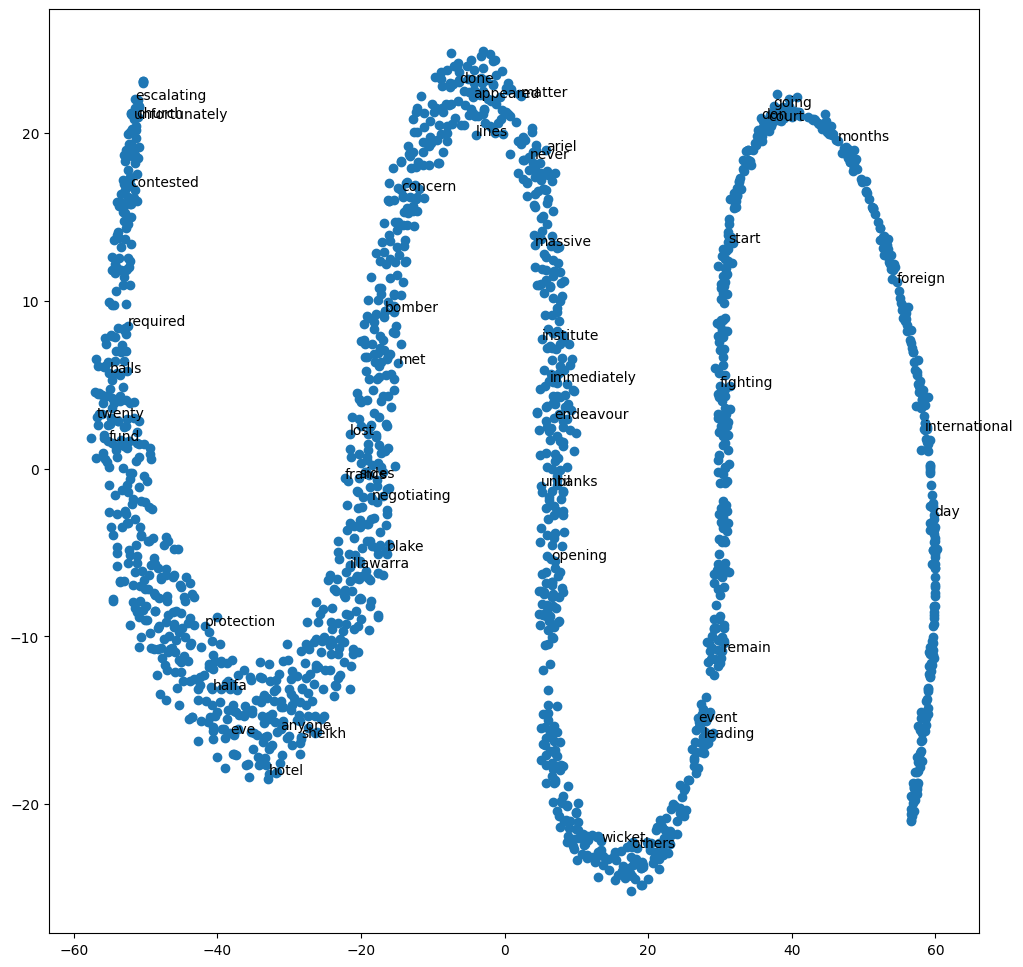

In [27]:
from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction
import numpy as np                                  # array handling


def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    # extract the words & their vectors, as numpy arrays
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)  # fixed-width numpy strings

    # reduce using t-SNE
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels


x_vals, y_vals, labels = reduce_dimensions(model)

def plot_with_plotly(x_vals, y_vals, labels, plot_in_notebook=True):
    from plotly.offline import init_notebook_mode, iplot, plot
    import plotly.graph_objs as go

    trace = go.Scatter(x=x_vals, y=y_vals, mode='text', text=labels)
    data = [trace]

    if plot_in_notebook:
        init_notebook_mode(connected=True)
        iplot(data, filename='word-embedding-plot')
    else:
        plot(data, filename='word-embedding-plot.html')


def plot_with_matplotlib(x_vals, y_vals, labels):
    import matplotlib.pyplot as plt
    import random

    random.seed(0)

    plt.figure(figsize=(12, 12))
    plt.scatter(x_vals, y_vals)

    #
    # Label randomly subsampled 50 data points
    #
    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, 50)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))

try:
    get_ipython()
except Exception:
    plot_function = plot_with_matplotlib
else:
    plot_function = plot_with_matplotlib

plot_function(x_vals, y_vals, labels)

Conclusion
----------

In this tutorial we learned how to train word2vec models on your custom data
and also how to evaluate it. Hope that you too will find this popular tool
useful in your Machine Learning tasks!

Links
-----

- API docs: :py:mod:`gensim.models.word2vec`
- `Original C toolkit and word2vec papers by Google <https://code.google.com/archive/p/word2vec/>`_.


